## Modeling Soybean yield using using Convolution Neural Network on raster data

In [ ]:
### Libraries

In [2]:
location = 'dataset/'

from IPython.core.display import display, HTML
from IPython.display import display_html
display(  HTML( '<style>.container { width:60% !important; }</style>' )  )

import os, random, time, datetime
import pandas as pd, re
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, scipy
from sklearn import *
import missingno as msno
import xgboost as xgb

from glob import glob
from scipy.io import loadmat

import scipy.stats as stats, random, math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.colors import ListedColormap

plt.style.use('classic')

# import remote sensing libraries
import geopandas as pdd
import rasterio as rio, shapely
import earthpy.plot as ep
from osgeo import gdal


# ml ai lib 
import tensorflow as tf, imageio, PIL
from tensorflow import *
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
import keras_tuner as ktuner 

%matplotlib inline

## Set Jupyter notebook display options for pandas
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 6

C:\Users\madhur\AppData\Local\Temp\ipykernel_23504\4184719459.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<br> 

### A. ML model to predict Soybean yield using Tabular data

The fields in the data are as follow:

    Variety: Variety of the Soybean crop
    S1, S2, S3, S4 : Soil components
    M1, M2, M3: Crop management parameters
    W1, W2, W3, W4: Weather components
    Yield: Crop yield value

<br>

In [3]:
soyb_df = pd.read_csv( location + 'soybean_data.csv'  )
soyb_df


,Variety,S_1,S_2,S_3,S_4,M_1,M_2,M_3,W_1,W_2,W_3,W_4,Yield
0,1,4.0900,15.3,396.90,4.98,0.00632,18.0,6.575,2.381979,0.475522,65.2,296.350195,24.0
1,2,4.9671,17.8,396.90,9.14,0.02731,0.0,6.421,7.071148,0.509165,78.9,241.620198,21.6
2,2,4.9671,17.8,392.83,4.03,0.02729,0.0,7.185,6.896941,0.580673,61.1,241.551476,34.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,2.1675,21.0,396.90,5.64,0.06076,0.0,6.976,11.854205,0.777569,91.0,273.421726,23.9
504,1,2.3889,21.0,393.45,6.48,0.10959,0.0,6.794,11.765196,0.679057,89.3,273.913622,22.0
505,1,2.5050,21.0,396.90,7.88,0.04741,0.0,6.030,12.007563,0.615699,80.8,273.623418,11.9


False

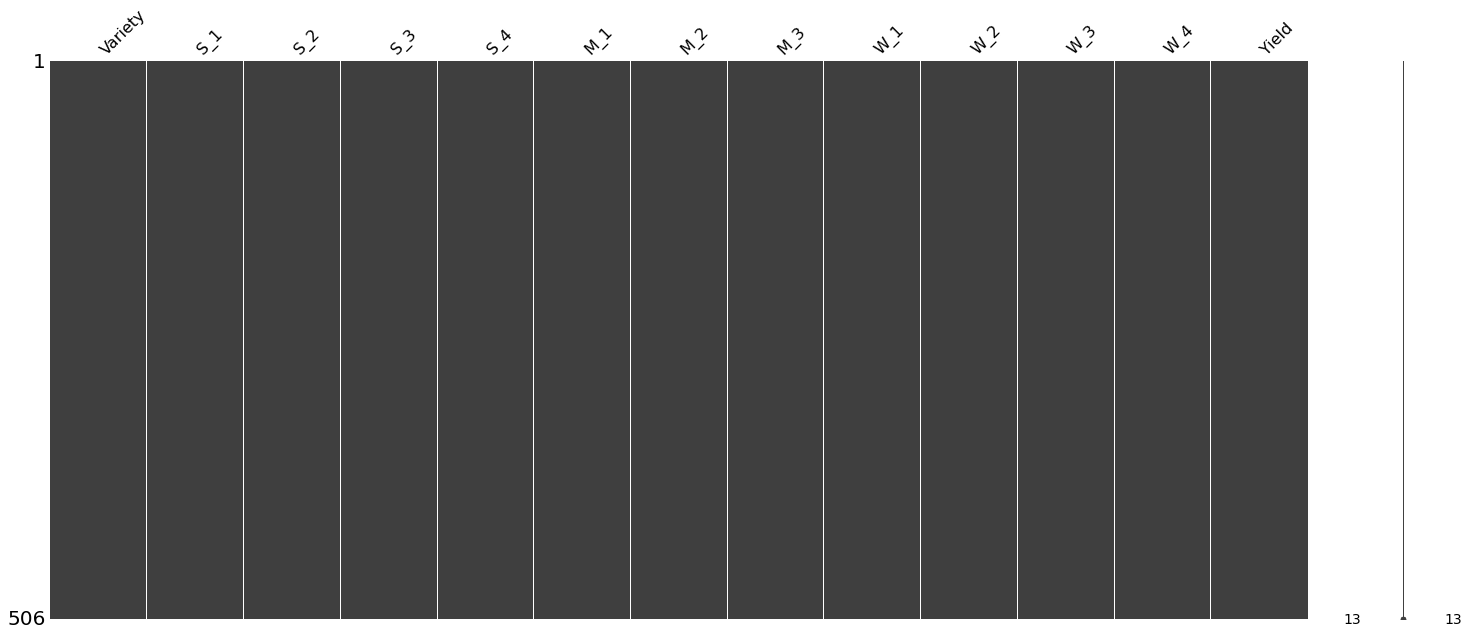

In [4]:
# checking for missing values

msno.matrix( soyb_df )
soyb_df.isnull().values.any()

<br>

#### Data preprocessing
<br>

In [5]:
from statsmodels.graphics.gofplots import qqplot

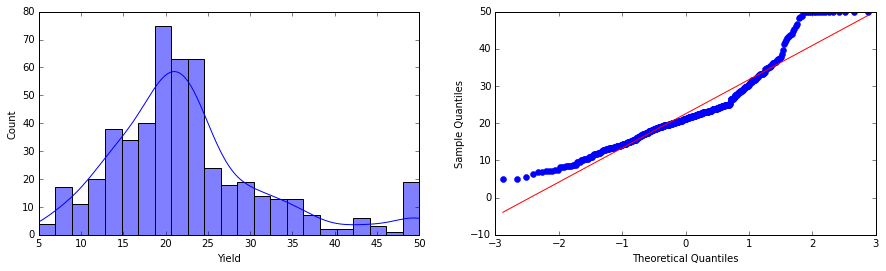

In [6]:
fg, ax = plt.subplots(  1,2, figsize= (15,4)  )

sns.histplot(  data= soyb_df, x= 'Yield', kde= True, ax= ax[0]  )
qqplot(  data= soyb_df.Yield, line= 's', ax= ax[1]  )

plt.show()

#### `Normalization` (Min-Max Scalar)

In this approach, the data is scaled to a fixed range — usually 0 to 1.
In contrast to standardization, the cost of having this bounded range is that we will end up with smaller standard deviations, which can <u>suppress the effect of outliers</u>. Thus <u>MinMax Scalar is sensitive to outliers</u>.

A Min-Max scaling is typically done via the following equation:<br><br>
$X_{n o r m}=\frac{X-X_{\min }}{X_{\max }-X_{\min }}$

In [7]:
minMaxScaler_Obj = sklearn.preprocessing.MinMaxScaler()

normalized_data_np = minMaxScaler_Obj.fit_transform( soyb_df )

normalized_df = pd.DataFrame(  normalized_data_np, columns= soyb_df.columns )

normalized_df

,Variety,S_1,S_2,S_3,S_4,M_1,M_2,M_3,W_1,W_2,W_3,W_4,Yield
0,0.000000,0.269203,0.287234,1.000000,0.089680,0.000000,0.18,0.577505,0.069166,0.352517,0.641607,0.208954,0.422222
1,0.043478,0.348962,0.553191,1.000000,0.204470,0.000236,0.00,0.547998,0.239056,0.384409,0.782698,0.104596,0.368889
2,0.043478,0.348962,0.553191,0.989737,0.063466,0.000236,0.00,0.694386,0.232744,0.452197,0.599382,0.104465,0.660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0.000000,0.094381,0.893617,1.000000,0.107892,0.000612,0.00,0.654340,0.412347,0.638850,0.907312,0.165235,0.420000
504,0.000000,0.114514,0.893617,0.991301,0.131071,0.001161,0.00,0.619467,0.409122,0.545463,0.889804,0.166173,0.377778
505,0.000000,0.125072,0.893617,1.000000,0.169702,0.000462,0.00,0.473079,0.417903,0.485402,0.802266,0.165619,0.153333


In [8]:
# train test split

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                            normalized_df.drop( columns= 'Yield' ), soyb_df['Yield'],
                            test_size= 20./100, random_state= 10 )

xtrn, xval, ytrn, yval = sklearn.model_selection.train_test_split(  xtrn, ytrn,
                                                                    test_size= 25./100, random_state= 10 )

print(  xtrn.shape, xval.shape, xtst.shape, ytrn.shape, yval.shape, ytst.shape  )

(303, 12) (101, 12) (102, 12) (303,) (101,) (102,)


### Ridge Regression

In [10]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = sklearn.linear_model.Ridge()
parameters = { 'alpha': alphas }
ridge_regressor = sklearn.model_selection.GridSearchCV( estimator= ridge, param_grid= parameters,
                                                        scoring='neg_mean_squared_error', cv= 5 )
ridge_regressor.fit( xtrn, ytrn )

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2....
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03])},
             scoring='neg_mean_squared_error')

In [11]:
print( ridge_regressor.best_params_, ridge_regressor.best_score_ )

{'alpha': 0.3289666123287841} -23.656438267385404


### Lasso Regression

In [12]:
lasso = sklearn.linear_model.Lasso()
parameters = { 'alpha': alphas }
lasso_regressor = sklearn.model_selection.GridSearchCV( estimator= lasso, param_grid= parameters,
                                                        scoring='neg_mean_squared_error', cv= 5 )

lasso_regressor.fit(  xtrn, ytrn )

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2....
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03])},
             scoring='neg_mean_squared_error')

In [13]:
print( lasso_regressor.best_params_, lasso_regressor.best_score_ )

{'alpha': 0.005} -23.93269312795432


In [14]:
yhat_lasso_val = lasso_regressor.predict( xval )
yhat_ridge_val = ridge_regressor.predict( xval )

print( f'Ridge - r2 - val : { sklearn.metrics.r2_score(yval, yhat_lasso_val) }' )
print( f'Lesso r2 - val): {  sklearn.metrics.r2_score(yval, yhat_ridge_val) } ')

Ridge - r2 - val : 0.6535462316097709
Lesso r2 - val): 0.6598340609175892 


In [15]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [16]:
yhat_lasso_tst = lasso_regressor.predict( xtst )
yhat_ridge_tst = ridge_regressor.predict( xtst )

metrics_tst_ls = {
    'RMSE': [ np.sqrt(mse(ytst,yhat_ridge_tst)), np.sqrt(mse(ytst,yhat_lasso_tst)) ], 
    'MSE':  [ mse(ytst,yhat_ridge_tst), mse(ytst,yhat_lasso_tst) ],
    'MAE':  [ mae(ytst,yhat_ridge_tst), mae(ytst,yhat_lasso_tst) ], 
    'R2':   [ r2_score(ytst, yhat_ridge_tst), r2_score(ytst, yhat_lasso_tst) ]
                 }  
metrics_tst_df = pd.DataFrame( metrics_tst_ls, index = ['Ridge', 'Lasso'] )

print(metrics_tst_df)

           RMSE        MSE       MAE        R2
Ridge  6.085387  37.031938  4.234358  0.645901
Lasso  6.087148  37.053371  4.238309  0.645696


### XGBOOST model

In [27]:
# dMatrix

xytrn_DMtrx = xgb.DMatrix(  data= xtrn, label= ytrn )
xytst_DMtrx = xgb.DMatrix(  data= xtst, label= ytst )

# initial hyper param dictn
pDictn = {  'objective': 'reg:squarederror', 'max_depth': 10   }
lambda_ls =  np.logspace(-6,0,50)
rmse_ls = []

# iter over lambda

for e_lambda in lambda_ls:
    
    pDictn['lambda'] = e_lambda
    
    # pass param with nascent k-v into cv
    xgb_CV  = xgb.cv(  params= pDictn, dtrain= xytrn_DMtrx,  num_boost_round= 3, nfold= 6, metrics= 'rmse',
                       as_pandas= True, seed= 10  )
    
    rmse_ls.append( xgb_CV['test-rmse-mean'].min() )
    
# convert lists to df

rmse_df = pd.DataFrame(  data= zip(lambda_ls,rmse_ls), columns= ['lambda_l2','rmse'] )
print( rmse_df.head() )

C:\Users\madhur\.conda\envs\mlai\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   lambda_l2      rmse
0   0.000001  8.497120
1   0.000001  8.496620
2   0.000002  8.513429
3   0.000002  8.505439
4   0.000003  8.502555


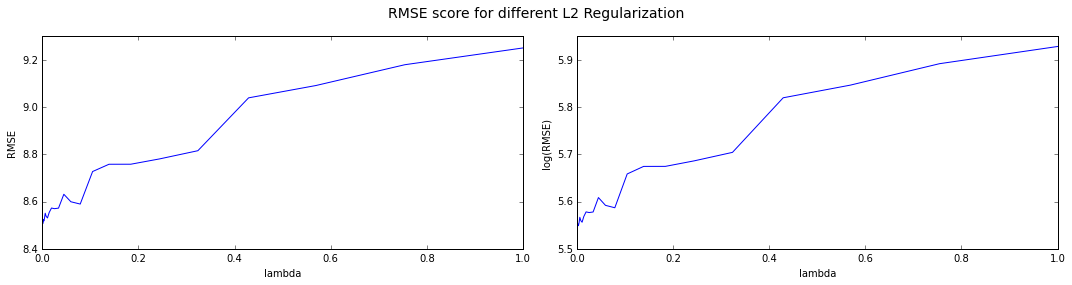

In [28]:
fg, ax = plt.subplots( 1,2, figsize= (15,4) )

ax[0].plot( rmse_df.lambda_l2, rmse_df.rmse );       ax[1].plot( rmse_df.lambda_l2, (rmse_df.rmse)**.8 )

ax[0].set( xlabel= 'lambda', ylabel= 'RMSE' );       ax[1].set( xlabel= 'lambda', ylabel= 'log(RMSE)'  )
fg.suptitle( 'RMSE score for different L2 Regularization', size= 14  )

# ax[1].set_yscale('log', base= 10)

plt.tight_layout(); plt.show()

#### Visualizing individual XGBoost trees

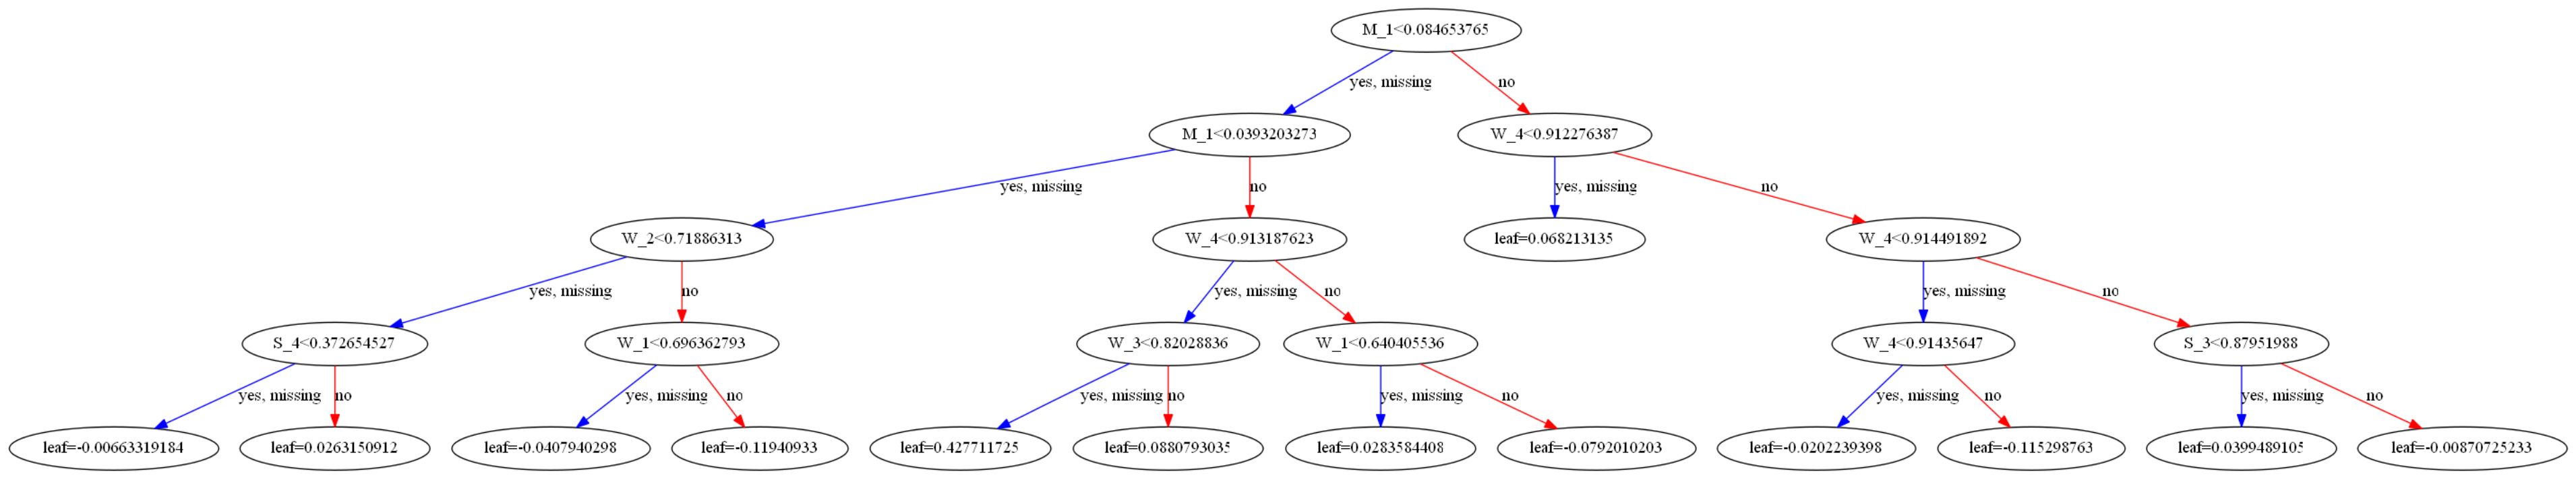

In [30]:
# model train/fit

total_trees = 50

pDictn = {  'objective':'reg:squarederror', 'max_depth':4, 'lambda':0.02  }

xgb_Reg_est = xgb.train(  params= pDictn, dtrain= xytrn_DMtrx, num_boost_round= total_trees  )

fg,ax = plt.subplots( figsize= (80,10) )

xgb.plot_tree( booster= xgb_Reg_est, ax= ax,
               num_trees= total_trees - 1  # <- last tree              
             )
plt.tight_layout()

#### Visualizing feature importances

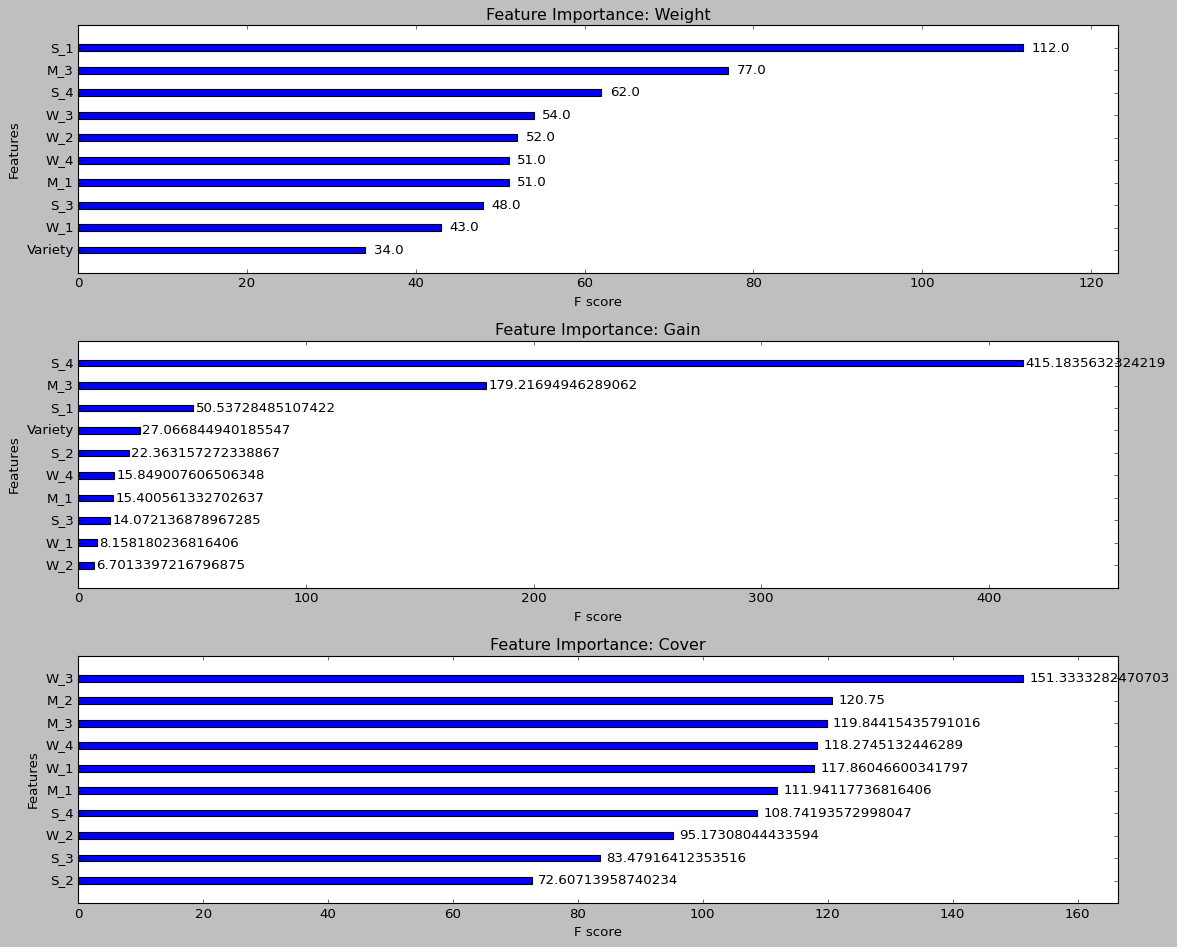

In [33]:
fg,ax = plt.subplots( 3,1, figsize= (15,4*3) )

xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'weight', ax= ax[0], title= 'Feature Importance: Weight'  )
xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'gain',   ax= ax[1], title= 'Feature Importance: Gain'  )
xgb.plot_importance(  booster= xgb_Reg_est, height= .3, max_num_features= 10, grid= False, importance_type= 'cover',  ax= ax[2], title= 'Feature Importance: Cover'  )

plt.tight_layout();  plt.show()

<br> 

### B. ML model to predict Soybean yield using Remote Sensing raster data

The data contains 22,986 .npz files that contain information about image and Y (average yield). **`npz`** is just a ZipFile containing multiple **`.npy`** files.

We will now iterate over the directory (containing raster images) and append the image and output data into lists (images and labels).

<br>

In [97]:
raster_ls = [];     lbl_ls = []

raster_file_loc = location+r'soybean_raster_imgs/'

for e_file in os.listdir( raster_file_loc ):
    e_raster_data = np.load(  file= raster_file_loc + str(e_file)  )
    
    raster_ls.append( e_raster_data['image'] )
    lbl_ls.append( e_raster_data['y'] )

In [98]:
xx = np.asarray( raster_ls )
yy = np.asarray( lbl_ls )

In [99]:
# train test split

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( xx, yy, test_size= 20./100, random_state= 10 )

xtrn, xval, ytrn, yval = sklearn.model_selection.train_test_split(  xtrn, ytrn,
                                                                    test_size= 25./100, random_state= 10 )

print(  xtrn.shape, xval.shape, xtst.shape, ytrn.shape, yval.shape, ytst.shape  )

(13791, 9, 32, 32) (4597, 9, 32, 32) (4598, 9, 32, 32) (13791,) (4597,) (4598,)


The shape of each file is (9, 32, 32) which we need to reshape into (32, 32, 9) as tensorflow expects the input for CNN in: <br>
*number of images, img x_dim, img y_dim, number of channels*

In [52]:
xtrn_reshp =  np.moveaxis(  xtrn, 1, -1  )
xval_reshp =  np.moveaxis(  xval, 1, -1  )
xtst_reshp =  np.moveaxis(  xtst, 1, -1  )

print(  xtrn_reshp.shape, xval_reshp.shape, xtst_reshp.shape  )

(13791, 32, 32, 9) (4597, 32, 32, 9) (4598, 32, 32, 9)


In [57]:
del raster_ls, lbl_ls, xtrn, xval, xtst, xx, yy

<br>

### Developing a Neural Network<br>

In [66]:
from tensorflow.keras import Sequential, callbacks, optimizers, backend
from tensorflow.keras.layers import Dense, Flatten
import keras_tuner as ktuner 

In [60]:
inp_shp = ( 32, 32, 9 )
xtrn_reshp.shape[-1]

9

In [70]:
def model_func( hp ):
    
    nn_model = Sequential()
    nn_model.add(  Flatten()  )
    
    # Adopting the range of Dense units [ 32, 512 ]
    hp_units = hp.Int(  'units', min_value= 32, max_value= 512, step= 32  )
    nn_model.add(  Dense( units= hp_units, activation='relu',
                           kernel_initializer='he_normal', input_shape= inp_shp )  )
    nn_model.add(  Dense( 10, activation='relu', kernel_initializer='he_normal' )  )
    nn_model.add(  Dense( 1 )  )
    
    # Adopting the different learning rate for the optimizer - 0.01, 0.001, 0.0001
    hp_learning_rate = hp.Choice( 'learning_rate', values= [1e-2, 1e-3, 1e-4] )
    nn_model.compile(  optimizer= optimizers.Adam( learning_rate= hp_learning_rate ), loss='mse' )
    
    return( nn_model )

In [76]:
early_stop_callback = keras.callbacks.EarlyStopping( monitor= 'loss', patience= 5 )

keras_tuner_1 = ktuner.Hyperband(  hypermodel= model_func, objective= 'val_loss',
                                   max_epochs= 10, factor= 3, directory='model_log'  )

keras_tuner_1.search(  xtrn_reshp, ytrn, epochs= 50,
                       validation_data= ( xval_reshp, yval ), callbacks= [early_stop_callback]  )

# Get the optimal hyperparameters
best_hparam = keras_tuner_1.get_best_hyperparameters( num_trials =1 )[0]

print(f"""
The optimal number of units in the first densely-connected layer is {best_hparam.get('units')} and
the optimal learning rate for the optimizer is {best_hparam.get('learning_rate')}.
""")


The optimal number of units in the first densely-connected layer is 224 and
the optimal learning rate for the optimizer is 0.01.



In [81]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs

model = keras_tuner_1.hypermodel.build( best_hparam )
history = model.fit(  xtrn_reshp, ytrn, epochs= 50, validation_data= (xval_reshp, yval) )

val_loss_per_epoch = history.history['val_loss']

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print( 'Best epoch: %d' % (best_epoch) )

Epoch 1/50
431/431 [==============================] - 2s 4ms/step - loss: 64.0688 - val_loss: 48.4660
Epoch 2/50
431/431 [==============================] - 1s 3ms/step - loss: 36.2607 - val_loss: 36.4987
Epoch 3/50
431/431 [==============================] - 1s 3ms/step - loss: 33.5885 - val_loss: 36.1020
Epoch 4/50
431/431 [==============================] - 1s 3ms/step - loss: 30.6859 - val_loss: 37.1061
Epoch 5/50
431/431 [==============================] - 1s 3ms/step - loss: 26.3545 - val_loss: 37.2477
Epoch 6/50
431/431 [==============================] - 1s 3ms/step - loss: 24.8618 - val_loss: 34.1767
Epoch 7/50
431/431 [==============================] - 1s 3ms/step - loss: 23.6468 - val_loss: 32.4572
Epoch 8/50
431/431 [==============================] - 1s 3ms/step - loss: 22.5487 - val_loss: 33.3807
Epoch 9/50
431/431 [==============================] - 1s 3ms/step - loss: 21.3862 - val_loss: 33.9251
Epoch 10/50
431/431 [==============================] - 1s 3ms/step - loss: 19.7149

In [103]:
tuned_nn_model = keras_tuner_1.hypermodel.build( best_hparam )

# Retrain the model
tuned_nn_model.fit(  xtrn_reshp, ytrn, epochs= best_epoch, validation_data= (xval_reshp,yval) )

Epoch 1/7
431/431 [==============================] - 2s 4ms/step - loss: 67.0553 - val_loss: 50.2875
Epoch 2/7
431/431 [==============================] - 1s 3ms/step - loss: 47.0553 - val_loss: 43.4666
Epoch 3/7
431/431 [==============================] - 1s 3ms/step - loss: 36.8127 - val_loss: 38.7182
Epoch 4/7
431/431 [==============================] - 1s 3ms/step - loss: 29.8447 - val_loss: 34.7757
Epoch 5/7
431/431 [==============================] - 1s 3ms/step - loss: 28.9289 - val_loss: 36.0110
Epoch 6/7
431/431 [==============================] - 1s 3ms/step - loss: 27.4543 - val_loss: 35.1725
Epoch 7/7
431/431 [==============================] - 1s 3ms/step - loss: 25.0842 - val_loss: 35.4421


In [104]:
tuned_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 224)               2064608   
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,066,869
Trainable params: 2,066,869
Non-trainable params: 0
_________________________________________________________________


In [105]:
predictions_val  = tuned_nn_model.predict( xval_reshp )
predictions_val

array([[40.78089 ],
       [43.896725],
       [27.163588],
       ...,
       [43.034496],
       [22.7204  ],
       [41.872665]], dtype=float32)

In [106]:
error = tuned_nn_model.evaluate(  xval_reshp, yval, verbose= 0 )
print( 'MSE: %.3f, RMSE: %.3f' % ( error, np.sqrt(error) ) )

# r2 score for cnn model
r2_score(  predictions_val, yval  )

MSE: 35.442, RMSE: 5.953


0.6326588560077988

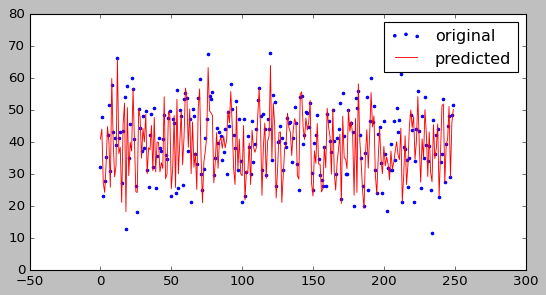

In [109]:
fig = plt.figure(figsize=(8, 4))
x_ax = range( len(predictions_val[:250]) )
plt.scatter(  x_ax, yval[:250], s= 5, color= 'blue', label= 'original'  )
plt.plot(  x_ax, predictions_val[:250], lw= 0.8, color= 'red', label= 'predicted'  )
plt.legend()

plt.show()

<br>

### Developing Convolution Neural Network<br>

In [108]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [112]:
def cnn_model(hp):
    
    cnn_model = Sequential()
    cnn_model.add(Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        # adding filter size or kernel size
        kernel_size=(3,3),
        activation='relu', 
        kernel_initializer='he_uniform', 
        input_shape=(32, 32, 9)))
    cnn_model.add(MaxPool2D((2, 2)))
    cnn_model.add(Conv2D(               
        filters=64,
        kernel_size=(3,3),
        activation='relu'))
    cnn_model.add(MaxPool2D((2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1))
   
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')
    
    return cnn_model

In [114]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=5)

In [117]:
# initialising the keras tuner
tuner = ktuner.Hyperband(  cnn_model, objective= 'val_loss', max_epochs= 10,
                           factor= 3, directory= 'CNN_model_log', project_name= 'cnn_model'  )

INFO:tensorflow:Reloading Oracle from existing project CNN_model_log\cnn_model\oracle.json


In [119]:
tuner.search(  xtrn_reshp, ytrn, epochs= 50,
               validation_data= (xval_reshp, yval), callbacks= [early_stopping]  )

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters( num_trials= 1 )[0]

print(f"""
The optimal number of units in the first CNN layer is {best_hps.get('conv_1_filter')} and
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 27s]
val_loss: 44.2977180480957

Best val_loss So Far: 28.516345977783203
Total elapsed time: 00h 08m 12s
INFO:tensorflow:Oracle triggered exit

The optimal number of units in the first CNN layer is 256 and
the optimal learning rate for the optimizer is 0.001.



In [122]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(  xtrn_reshp, ytrn, epochs= 50, validation_data= (xval_reshp,yval)  )

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index( min(val_loss_per_epoch) ) + 1
print( 'Best epoch: %d' % (best_epoch) )

Epoch 1/50
431/431 [==============================] - 3s 6ms/step - loss: 117.5246 - val_loss: 56.1702
Epoch 2/50
431/431 [==============================] - 2s 5ms/step - loss: 52.2521 - val_loss: 45.0122
Epoch 3/50
431/431 [==============================] - 2s 5ms/step - loss: 42.4298 - val_loss: 48.5259
Epoch 4/50
431/431 [==============================] - 2s 6ms/step - loss: 39.0343 - val_loss: 36.7115
Epoch 5/50
431/431 [==============================] - 2s 6ms/step - loss: 35.8501 - val_loss: 35.1537
Epoch 6/50
431/431 [==============================] - 2s 6ms/step - loss: 34.0667 - val_loss: 37.6657
Epoch 7/50
431/431 [==============================] - 2s 6ms/step - loss: 31.4934 - val_loss: 43.7846
Epoch 8/50
431/431 [==============================] - 2s 5ms/step - loss: 30.7917 - val_loss: 30.5170
Epoch 9/50
431/431 [==============================] - 2s 5ms/step - loss: 28.8882 - val_loss: 31.9003
Epoch 10/50
431/431 [==============================] - 2s 5ms/step - loss: 27.071

In [123]:
tuned_cnn_model = tuner.hypermodel.build( best_hps )

# Retrain the model
tuned_cnn_model.fit(  xtrn_reshp, ytrn, epochs= best_epoch, validation_data= (xval_reshp, yval)  )

Epoch 1/24
431/431 [==============================] - 3s 6ms/step - loss: 111.1369 - val_loss: 49.3148
Epoch 2/24
431/431 [==============================] - 2s 6ms/step - loss: 47.1273 - val_loss: 41.7096
Epoch 3/24
431/431 [==============================] - 2s 6ms/step - loss: 39.9646 - val_loss: 38.3253
Epoch 4/24
431/431 [==============================] - 2s 6ms/step - loss: 36.8070 - val_loss: 34.8703
Epoch 5/24
431/431 [==============================] - 2s 6ms/step - loss: 34.7224 - val_loss: 34.9763
Epoch 6/24
431/431 [==============================] - 2s 6ms/step - loss: 32.3288 - val_loss: 36.1557
Epoch 7/24
431/431 [==============================] - 2s 6ms/step - loss: 30.5830 - val_loss: 32.0223
Epoch 8/24
431/431 [==============================] - 2s 6ms/step - loss: 29.4279 - val_loss: 39.7933
Epoch 9/24
431/431 [==============================] - 2s 6ms/step - loss: 28.4577 - val_loss: 30.1020
Epoch 10/24
431/431 [==============================] - 2s 5ms/step - loss: 24.774

In [124]:
tuned_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 256)       20992     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        147520    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [125]:
predictions_val  = tuned_cnn_model.predict( xval_reshp )
predictions_val

array([[31.731274],
       [43.112705],
       [26.634113],
       ...,
       [34.788853],
       [23.641712],
       [41.587387]], dtype=float32)

#### CNN model metrics on Validation set

In [127]:
error = tuned_cnn_model.evaluate(  xval_reshp, yval, verbose= 0  )
print(  'MSE: %.3f, RMSE: %.3f' % ( error,sqrt(error) )  )

# r2 score for cnn model
r2_score(  predictions_val, yval  )

MSE: 25.940, RMSE: 5.093


0.7458085162977603

<br>

### CNN with K-fold<br>

In [129]:
from sklearn.model_selection import KFold

n_split = 5

loss_per_fold = []

# k-fold cross validation model

fold_no = 1

for train_index,val_index in KFold(n_split).split(X_main_reshaped):
    
    x_train, x_val = X_main_reshaped[train_index], X_main_reshaped[val_index]
    y_train, y_val = y_main[train_index], y_main[val_index]
    
    #clear 
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # fit data to model
    history = tuned_cnn_model.fit( x_train, y_train, epochs= 20 )
    
    # evalutate metrics
    scores = tuned_cnn_model.evaluate( x_val, y_val, verbose = 0 )
    loss_per_fold.append(scores)
    
    print(  f'Score for fold {fold_no}: {tuned_cnn_model.metrics_names} of {scores}'  )
        
    # increase fold number
    fold_no = fold_no + 1

Epoch 1/20
460/460 [==============================] - 2s 5ms/step - loss: 25.1713
Epoch 2/20
460/460 [==============================] - 2s 5ms/step - loss: 21.5655
Epoch 3/20
460/460 [==============================] - 2s 5ms/step - loss: 19.5570
Epoch 4/20
460/460 [==============================] - 2s 5ms/step - loss: 17.1767
Epoch 5/20
460/460 [==============================] - 2s 5ms/step - loss: 15.5660
Epoch 6/20
460/460 [==============================] - 2s 5ms/step - loss: 14.4868
Epoch 7/20
460/460 [==============================] - 2s 5ms/step - loss: 13.1026
Epoch 8/20
460/460 [==============================] - 2s 5ms/step - loss: 11.8642
Epoch 9/20
460/460 [==============================] - 2s 5ms/step - loss: 10.5574
Epoch 10/20
460/460 [==============================] - 2s 5ms/step - loss: 10.1320
Epoch 11/20
460/460 [==============================] - 2s 5ms/step - loss: 9.2840
Epoch 12/20
460/460 [==============================] - 2s 5ms/step - loss: 8.8069
Epoch 13/20
460

Epoch 19/20
460/460 [==============================] - 2s 5ms/step - loss: 2.0332
Epoch 20/20
460/460 [==============================] - 2s 5ms/step - loss: 2.0457
Score for fold 5: ['loss'] of 3.843085289001465


In [131]:
print('Score per fold')
for i in range(0, len(loss_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')

Score per fold
> Fold 1 - Loss: 29.03430938720703
> Fold 2 - Loss: 10.80633544921875
> Fold 3 - Loss: 6.240664482116699
> Fold 4 - Loss: 4.821691989898682
> Fold 5 - Loss: 3.843085289001465
Average scores for all folds:
> Loss: 10.949217319488525


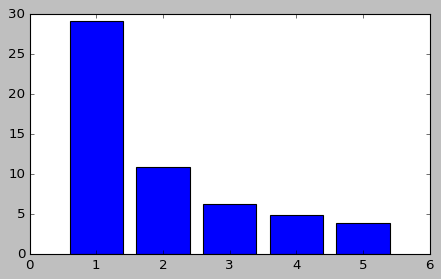

In [135]:
fig = plt.figure( figsize= (5,3) )
ax = fig.add_axes([0,0,1,1])
ax.bar([1, 2, 3, 4, 5],loss_per_fold)
plt.show()

In [138]:
# Predicting over test data
X_test_reshaped = X_test.reshape( xtst.shape[0], 32, 32, 9)


In [152]:
# NN network vs CNN

predictions_mlp_test  = tuned_nn_model.predict( xtst_reshp )
predictions_cnn_test  = tuned_cnn_model.predict( xtst_reshp )

# evaluate the MLPmodel
print("MLP Results:")
error = tuned_nn_model.evaluate( xtst_reshp, ytst, verbose= 0 )
print(' MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)) )
print(r2_score(predictions_mlp_test, ytst))


# evaluate the CNN model
print("\nCNN Results:")
error = tuned_cnn_model.evaluate( xtst_reshp, ytst, verbose= 0 )
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
print(r2_score(predictions_cnn_test, ytst))

MLP Results:
MSE: 36.835, RMSE: 6.069
0.6866333270049141

CNN Results:
MSE: 25.723, RMSE: 5.072
0.7723077991805609
